In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 
import statsmodels.api as sm 
from statsmodels.tsa.api import Holt
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize = (20,10))
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('font', size = 20)

import warnings
warnings.filterwarnings('ignore')



In [2]:
def plot_samples(target_var):
    '''
   this function will plot everything
   '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])

    plt.title(col)

    
# define evaluation function to compute rmse
def evaluate(target_var):
    '''
    the evaluate function will take in the actual values and the predicted values
    and compute the mean_squared_error and then take the sqrt returning a rounded rmse
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])),2)
    return rmse


# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.2f}'.format(rmse))
    plt.show()

    
# Define function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function will take in the model type as a string, target variable
    as a string, and run the evaluate function to compute rmse, 
    and append to the dataframe a row with the model type, 
    target variable and rmse. 
    '''
    rmse = evaluate(target_var)
    d= {'model_type':[model_type], 'target_var':[target_var], 'rmse':[rmse]}
    d= pd.DataFrame(d)
    return eval_df.append(d, ignore_index= True)


def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [temp],}, index = validate.index)
    return yhat_df


# plot and evaluate: plot
def plot_and_eval_test(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = sqrt(mean_squared_error(test['AverageTemperature'], yhat_df['AverageTemperature']))
    print(target_var, '--RMSE: {:.2f}'.format(rmse))
    plt.show()



# Time Series End to End Mini Project 
---

## Objective
---
The goal of this mini-project is to practice what I've learned at each stage of the pipeline throughout the time series module. I will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. I'll select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).

### Acquire and Prep

In [3]:
## Read in the data via CSV
temp = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [4]:
## Quick look at the info
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [5]:
## I have a fascination with Australia so thats what I'm going to take a closer look at
aussie = temp[temp['Country'] == 'Australia'].copy()

In [6]:
# Looks like I have a couple of nulls I'll have to fill. DT is going to need to be a datetime object too
aussie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1935 entries, 34816 to 36750
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             1935 non-null   object 
 1   AverageTemperature             1930 non-null   float64
 2   AverageTemperatureUncertainty  1930 non-null   float64
 3   Country                        1935 non-null   object 
dtypes: float64(2), object(2)
memory usage: 75.6+ KB


In [7]:
# Im not actually aussie so im gonna have to convert those celsius numbers to fahrenheit 
aussie.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
34816  1852-07-01              14.116                          1.530   
34817  1852-08-01              15.330                          1.400   
34818  1852-09-01              18.740                          1.446   
34819  1852-10-01              21.984                          1.493   
34820  1852-11-01              24.073                          1.466   

         Country  
34816  Australia  
34817  Australia  
34818  Australia  
34819  Australia  
34820  Australia

In [8]:
# Lets conver dt to a date time object
aussie.loc[:,'dt'] = pd.to_datetime(aussie['dt'])

In [9]:
## much better
aussie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1935 entries, 34816 to 36750
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             1935 non-null   datetime64[ns]
 1   AverageTemperature             1930 non-null   float64       
 2   AverageTemperatureUncertainty  1930 non-null   float64       
 3   Country                        1935 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 75.6+ KB


In [10]:
## set that as our new index
aussie = aussie.set_index('dt').sort_index()

In [11]:
## Checking my work
aussie

AverageTemperature  AverageTemperatureUncertainty    Country
dt                                                                      
1852-07-01              14.116                          1.530  Australia
1852-08-01              15.330                          1.400  Australia
1852-09-01              18.740                          1.446  Australia
1852-10-01              21.984                          1.493  Australia
1852-11-01              24.073                          1.466  Australia
...                        ...                            ...        ...
2013-05-01              19.377                          0.229  Australia
2013-06-01              16.018                          0.251  Australia
2013-07-01              15.933                          0.187  Australia
2013-08-01              17.748                          0.380  Australia
2013-09-01                 NaN                            NaN  Australia

[1935 rows x 3 columns]

In [12]:
# Foward fill my missing data 
aussie = aussie.fillna(method = 'ffill')

In [13]:
# Converting to the temp im more comfortable with
aussie.AverageTemperature = round(aussie.AverageTemperature * 9/5 +32, 0)

In [14]:
# Checking my work 
aussie.head()

AverageTemperature  AverageTemperatureUncertainty    Country
dt                                                                      
1852-07-01                57.0                          1.530  Australia
1852-08-01                60.0                          1.400  Australia
1852-09-01                66.0                          1.446  Australia
1852-10-01                72.0                          1.493  Australia
1852-11-01                75.0                          1.466  Australia

In [15]:
aussie.tail()

AverageTemperature  AverageTemperatureUncertainty    Country
dt                                                                      
2013-05-01                67.0                          0.229  Australia
2013-06-01                61.0                          0.251  Australia
2013-07-01                61.0                          0.187  Australia
2013-08-01                64.0                          0.380  Australia
2013-09-01                64.0                          0.380  Australia

In [16]:
aussie.AverageTemperatureUncertainty.describe()

count    1935.000000
mean        0.481437
std         0.451922
min         0.076000
25%         0.187000
50%         0.265000
75%         0.567000
max         2.361000
Name: AverageTemperatureUncertainty, dtype: float64

### Exploration

<AxesSubplot:xlabel='dt'>

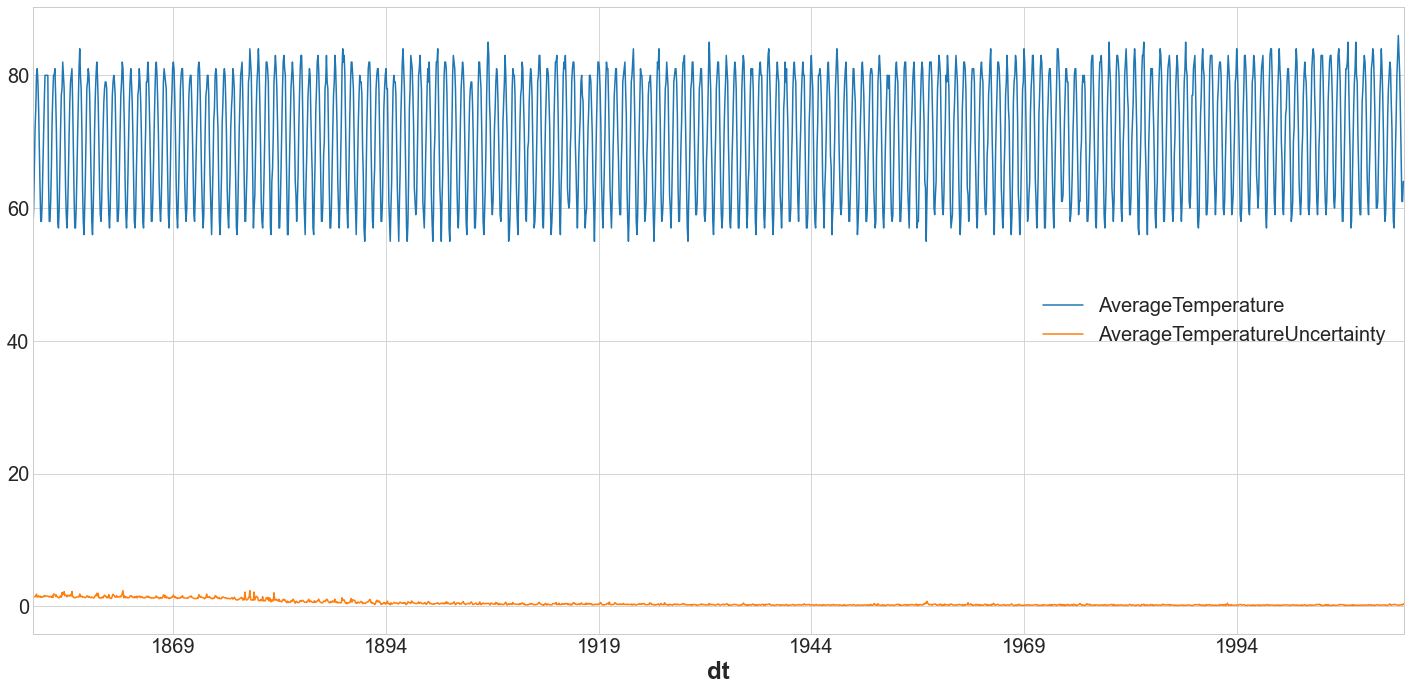

In [17]:
aussie.plot()

**Take aways**

- our data appears to be fairly accurate after about 1894 as far asuncertanty is concerned, which makes sense as recording and technology imporves. 
- there are heavy patterns of seasonality, Im calling it now cyclic patterns are going to produce the best model moving foward.
- there doesnt appear to be any large gaps or anomolies in the data so ill be using the entire data set

In [18]:
# Before any further analysis lets split our data 
train = aussie['1852':'1952']
validate = aussie['1953':'1999']
test = aussie['2000':]

In [19]:
# Total shape
aussie.shape

(1935, 3)

In [20]:
# breakdown of new sets, Train contains about 62%, Validate 29%, test has about 9%
# data was divided this way to encorporate global warming which has escalated throughoout the years.
train.shape, validate.shape, test.shape

((1206, 3), (564, 3), (165, 3))

<AxesSubplot:xlabel='dt'>

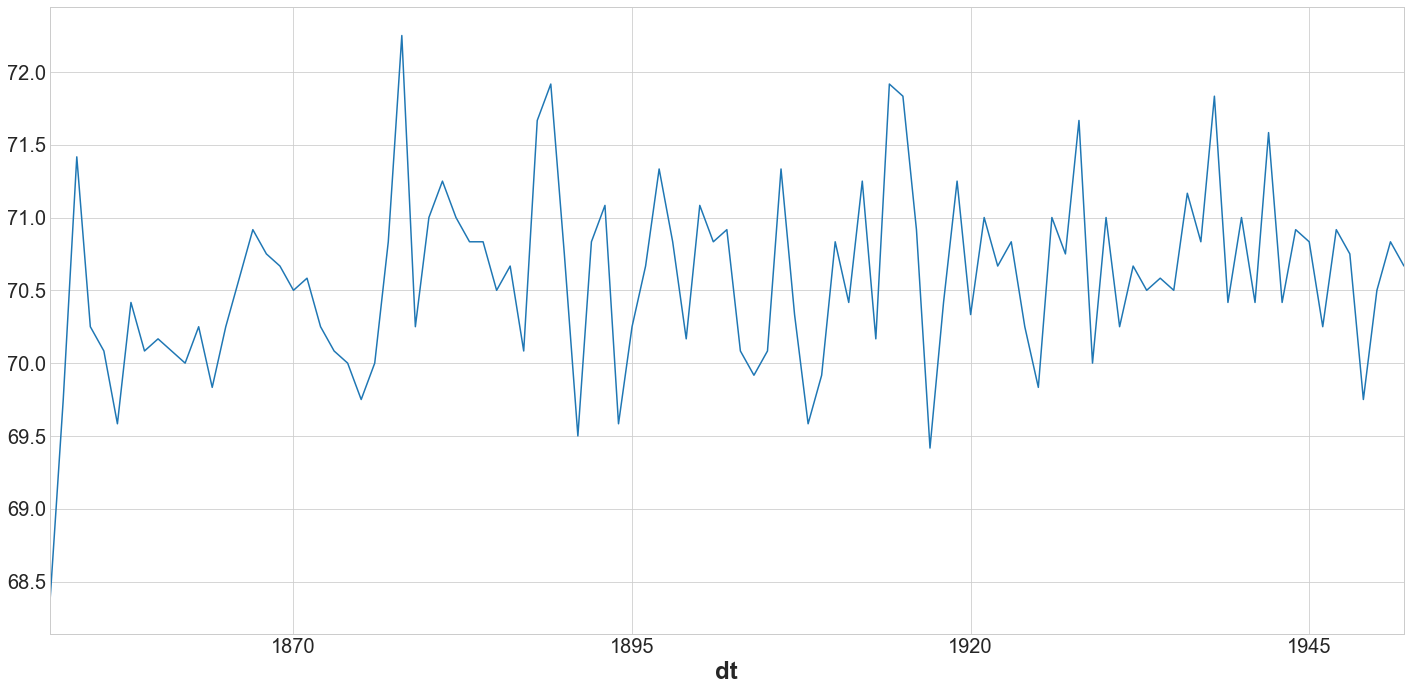

In [21]:
year_temp = train.AverageTemperature.resample('1Y').mean()
year_temp.plot()

- while these changes look drastic, looking at the largest peak to peak change is 3 degrees which is realativley tame. 

<AxesSubplot:xlabel='dt'>

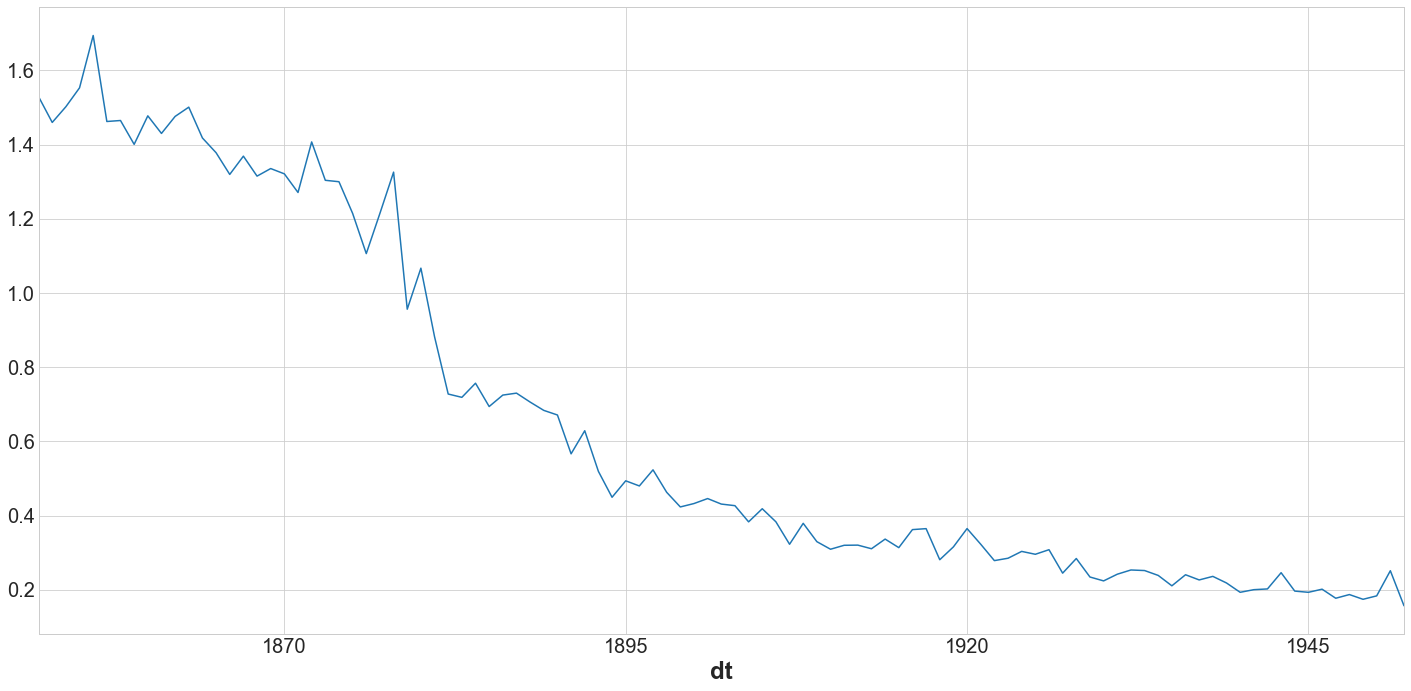

In [22]:
year_cert = train.AverageTemperatureUncertainty.resample('1Y').mean()
year_cert.plot()

- as discussed earlier the uncertanty falls drastically as technology and recording imporved

In [23]:
month_temp = train.AverageTemperature.resample('1M').mean()

<AxesSubplot:xlabel='dt'>

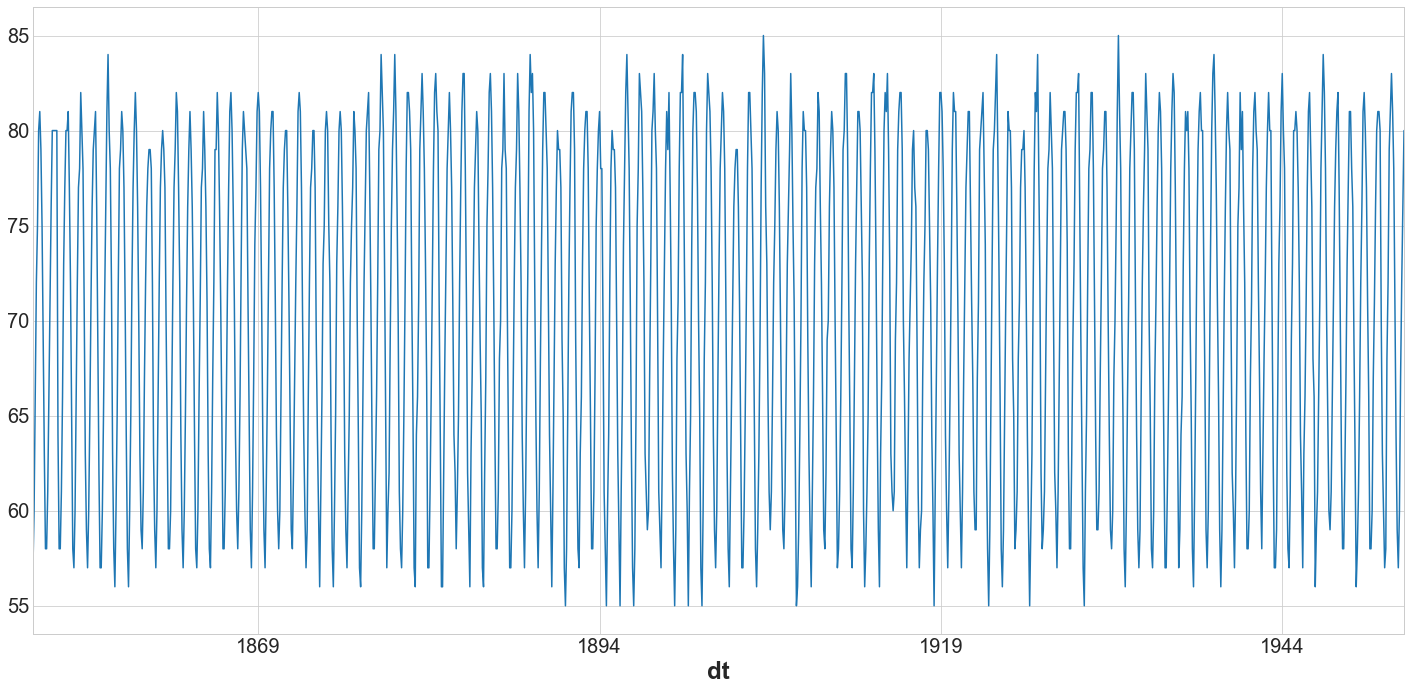

In [24]:
month_temp.plot()

- its amazing how consistent this data is, I think were going to be able to get a rocking model 

In [25]:
train.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')

In [26]:
# moving foward I'll be dropping country(i've made this entire dataframe 1 country)
# and ill be dropping the certanty level with the highest being 2.5 it falls into our 95% range
# and it hovers around .002 after about 1900
train = train.drop(columns = ['Country','AverageTemperatureUncertainty'])
validate = validate.drop(columns = ['Country', 'AverageTemperatureUncertainty'])
test = test.drop(columns = ['Country', 'AverageTemperatureUncertainty' ])

In [27]:
# checking my work 
train.columns

Index(['AverageTemperature'], dtype='object')

In [28]:
## Lets take a look at seasonal decomposition 
y = train['AverageTemperature']
month = y.resample('1M').mean()
result = sm.tsa.seasonal_decompose(month)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

y  trend   seasonal  resid
dt                                       
1852-07-31  57.0    NaN -13.516858    NaN
1852-08-31  60.0    NaN  -9.902380    NaN
1852-09-30  66.0    NaN  -4.227717    NaN
1852-10-31  72.0    NaN   1.588361    NaN
1852-11-30  75.0    NaN   6.880027    NaN

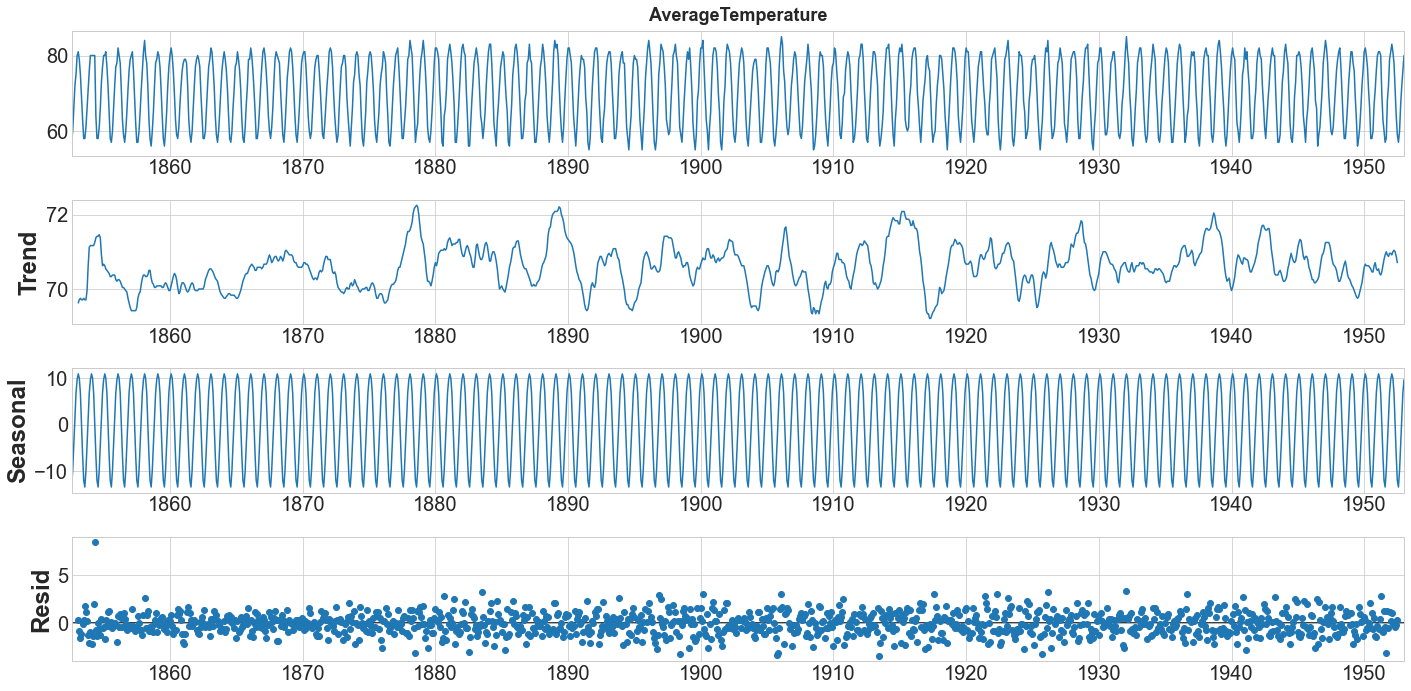

In [29]:
result.plot()
None

- great seasonality using months

In [30]:
y = train['AverageTemperature']
month = y.resample('1Y').mean()
result = sm.tsa.seasonal_decompose(month)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

y      trend  seasonal  resid
dt                                               
1852-12-31  68.333333  68.333333       0.0    0.0
1853-12-31  69.750000  69.750000       0.0    0.0
1854-12-31  71.416667  71.416667       0.0    0.0
1855-12-31  70.250000  70.250000       0.0    0.0
1856-12-31  70.083333  70.083333       0.0    0.0

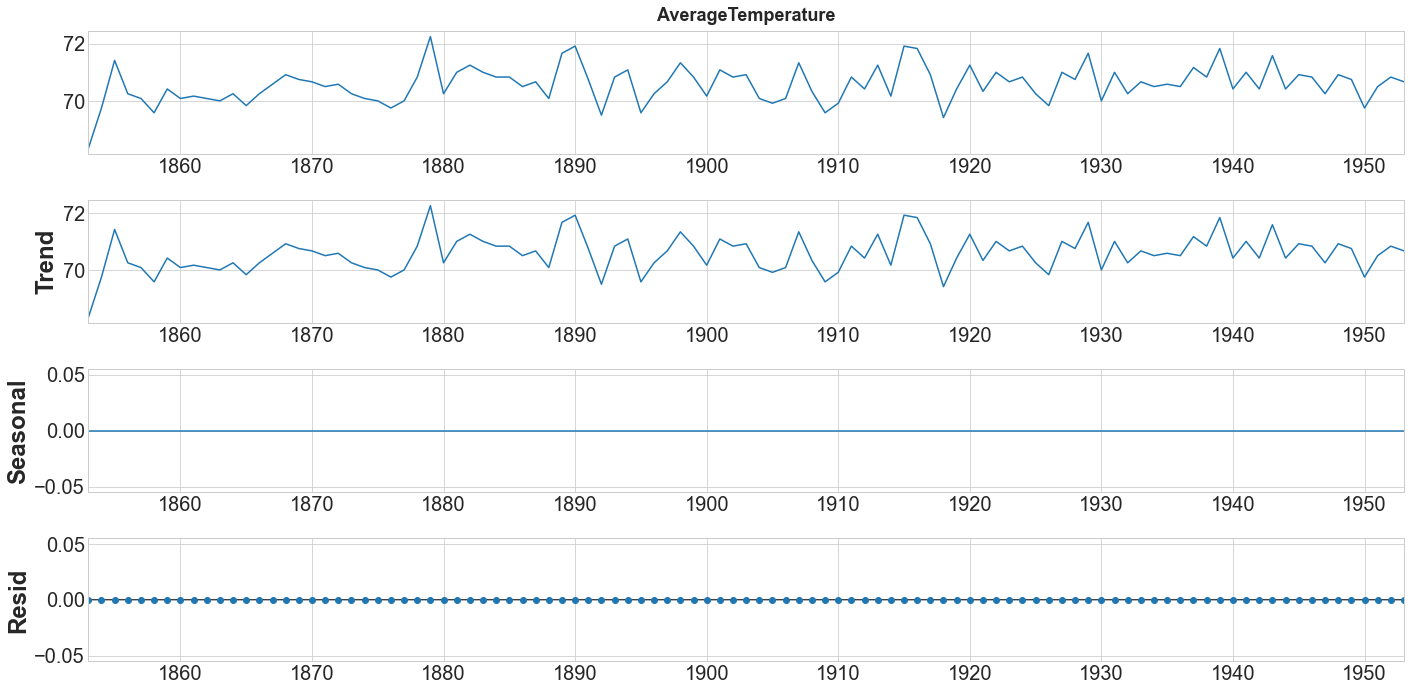

In [31]:
result.plot()
None

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

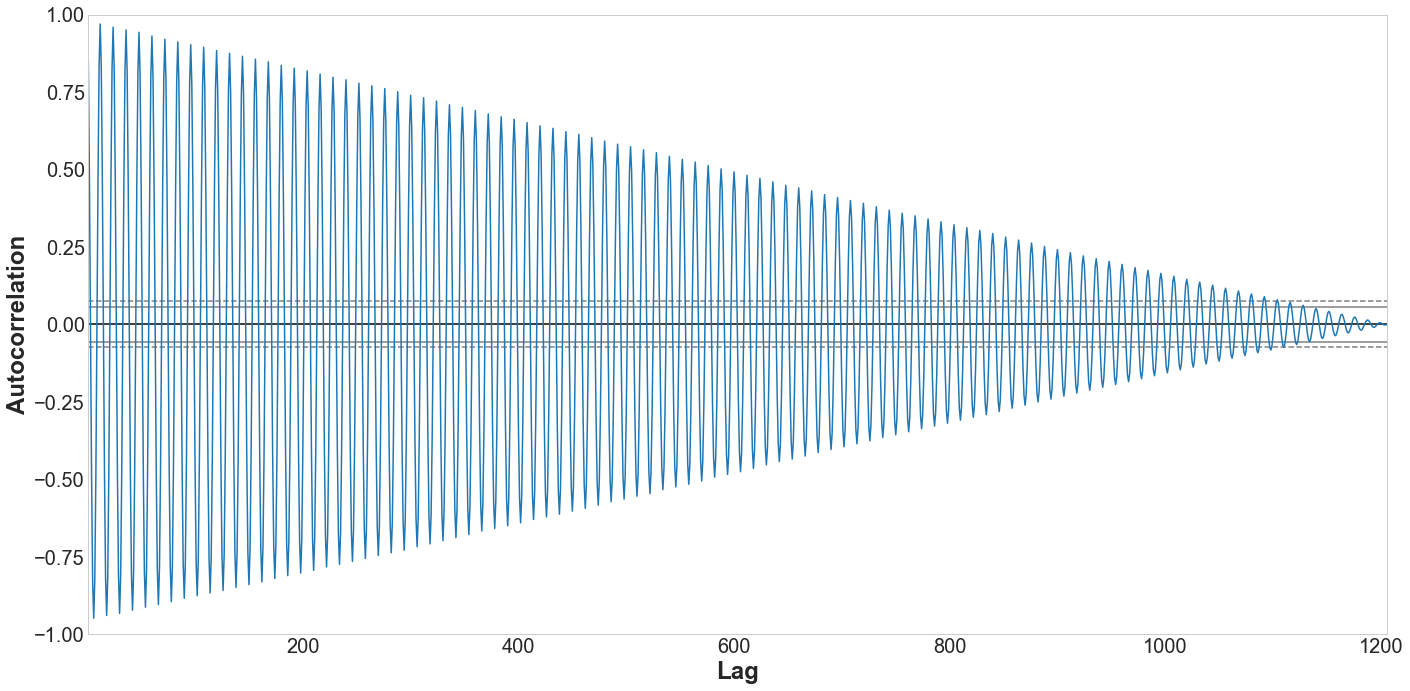

In [32]:
# lets look at autocorrelation plot
pd.plotting.autocorrelation_plot(y.resample('m').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

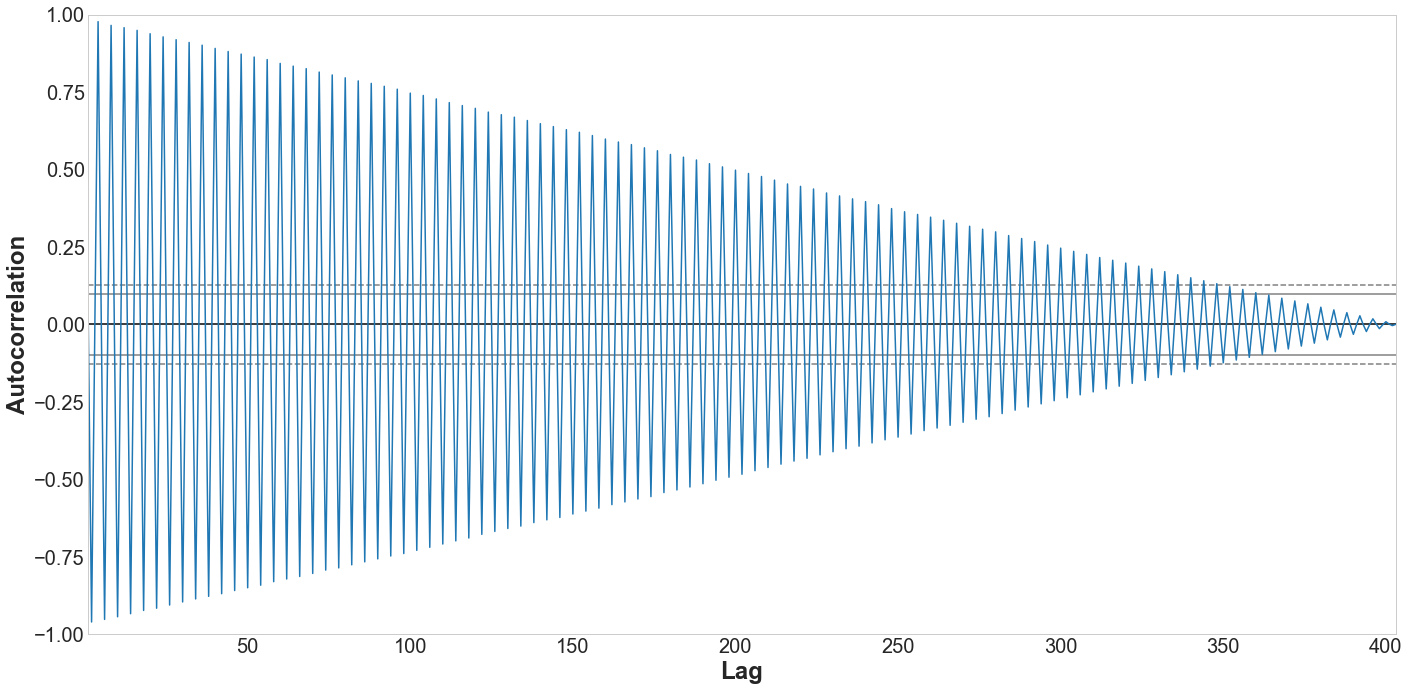

In [33]:
pd.plotting.autocorrelation_plot(y.resample('3m').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

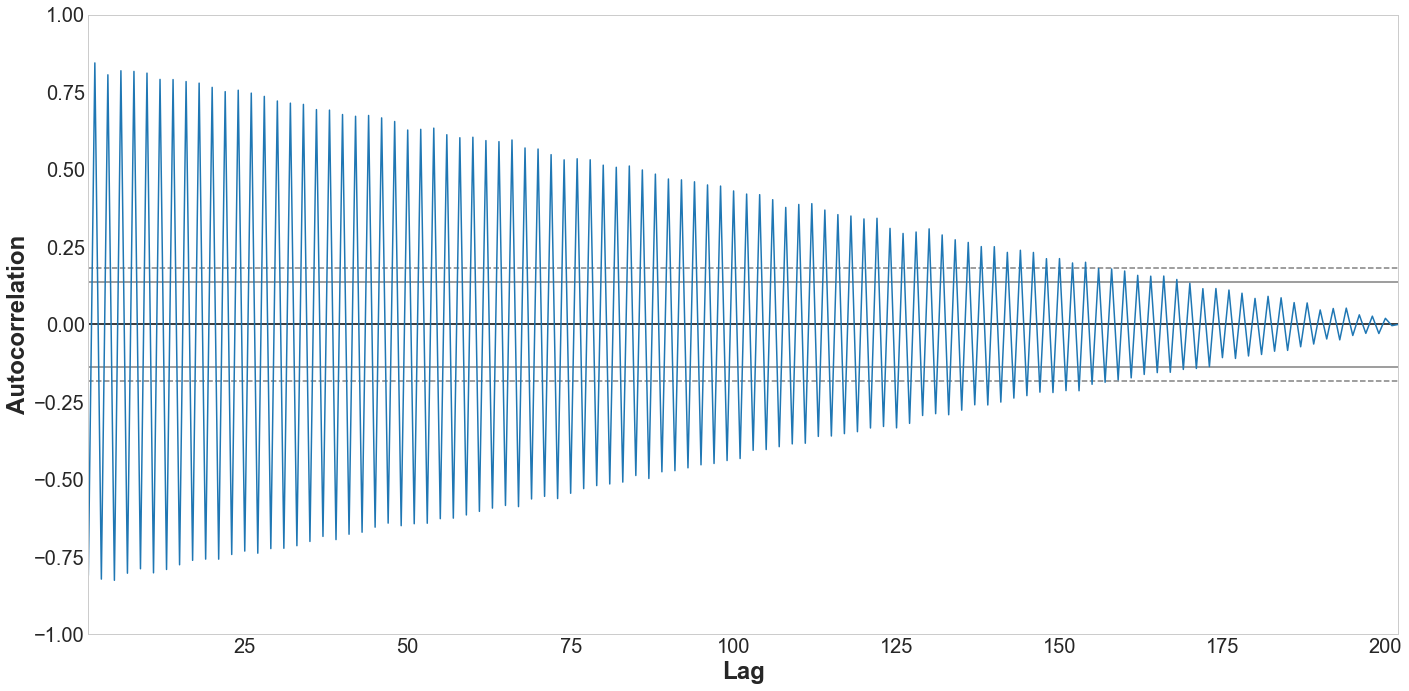

In [34]:
pd.plotting.autocorrelation_plot(y.resample('6m').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

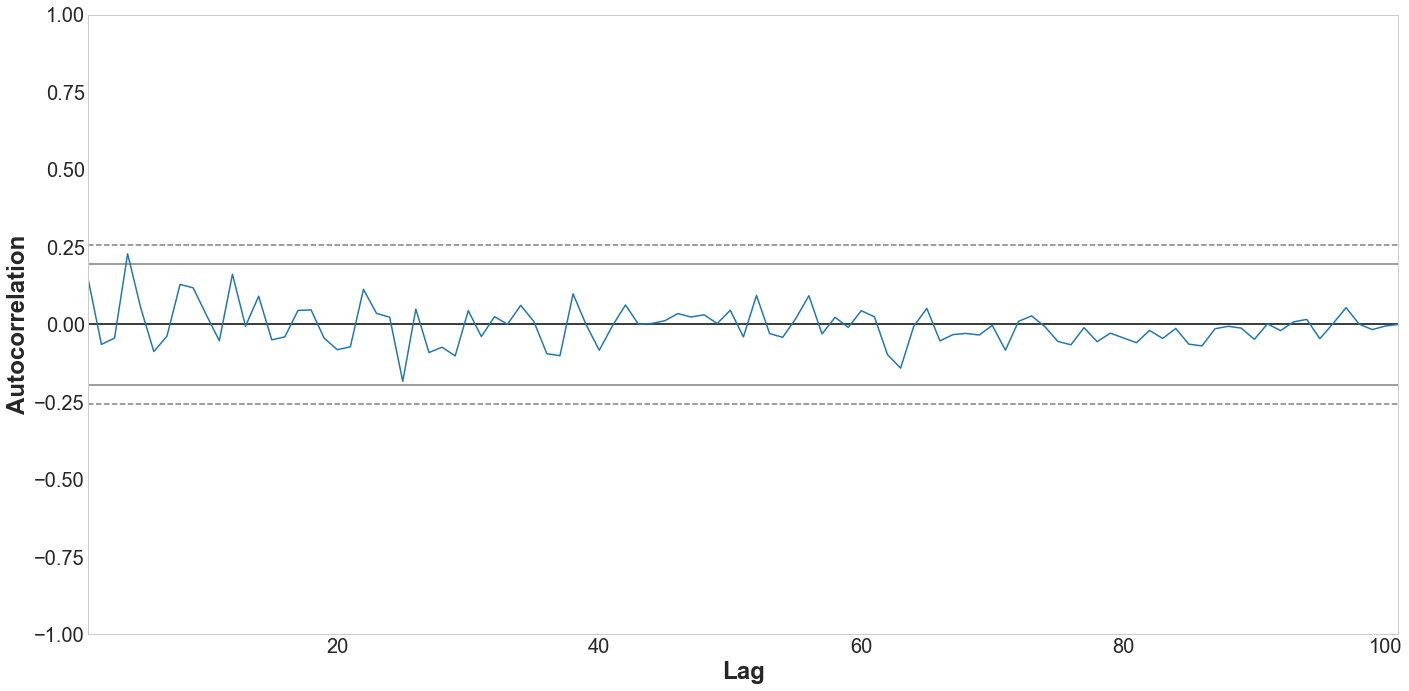

In [35]:
pd.plotting.autocorrelation_plot(y.resample('Y').mean())

- monthly seems to have the most correlation. The correlation weakens over time and is non existant by the time we hit yearly

## Forecasting
---
### Last Known Value

In [36]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])
eval_df

Empty DataFrame
Columns: [model_type, target_var, rmse]
Index: []

In [37]:
temp = train['AverageTemperature'][-1:][0]

yhat_df = make_predictions()
yhat_df.head()

AverageTemperature
dt                            
1953-01-01                80.0
1953-02-01                80.0
1953-03-01                80.0
1953-04-01                80.0
1953-05-01                80.0

AverageTemperature --RMSE: 12.28


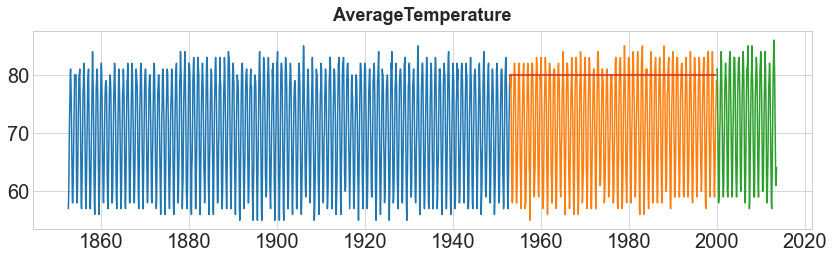

In [38]:
for col in train.columns:
    plot_and_eval(col)

In [39]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

In [40]:
eval_df

model_type          target_var   rmse
0  last_observed_value  AverageTemperature  12.28

- this is bad
- to be clear im only doing this as a requirment I'm really excited to run my cyclic model

### Simple Average

In [41]:
temp = round(train['AverageTemperature'].mean(), 2)
yhat_df = make_predictions()
yhat_df.head()

AverageTemperature
dt                            
1953-01-01               70.59
1953-02-01               70.59
1953-03-01               70.59
1953-04-01               70.59
1953-05-01               70.59

AverageTemperature --RMSE: 8.81


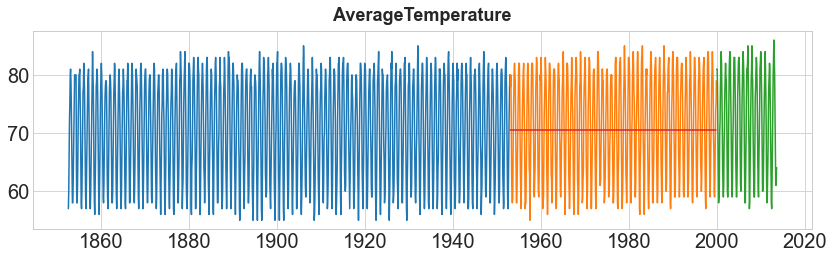

In [42]:
for col in train.columns:
    plot_and_eval(col)

In [43]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)
eval_df

model_type          target_var   rmse
0  last_observed_value  AverageTemperature  12.28
1       simple_average  AverageTemperature   8.81

- better but still not great, moving foward this will be our baseline
### Moving Average

AverageTemperature --RMSE: 12.28


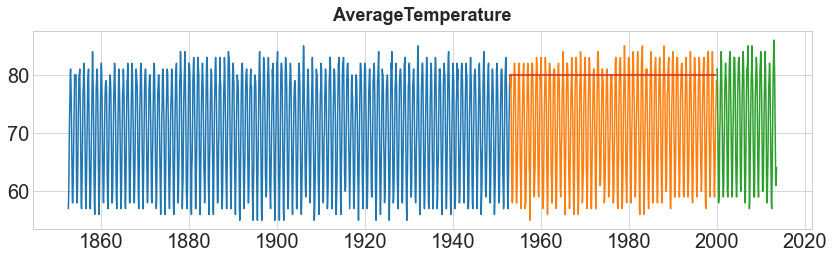

AverageTemperature --RMSE: 10.97


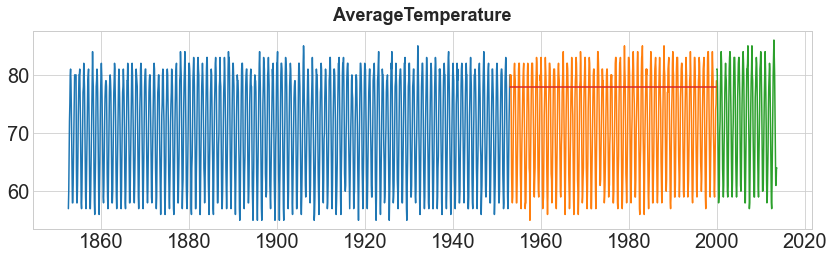

AverageTemperature --RMSE: 9.90


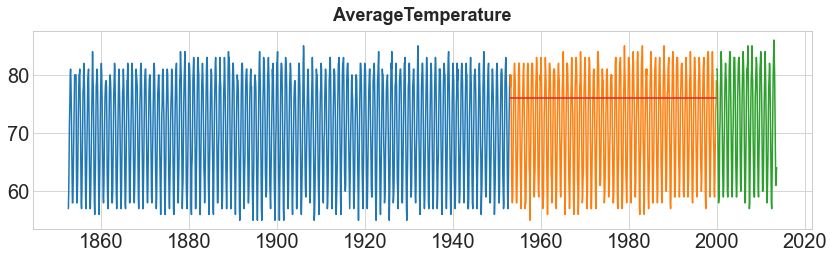

AverageTemperature --RMSE: 9.08


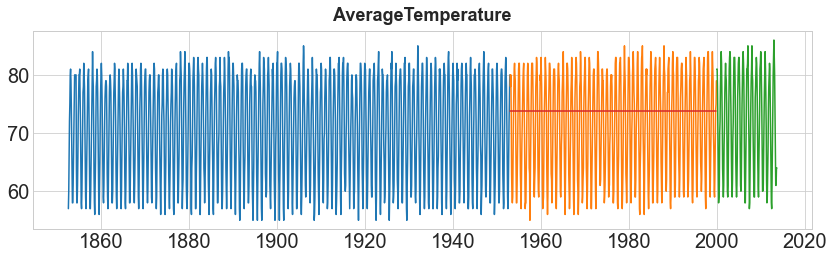

AverageTemperature --RMSE: 8.78


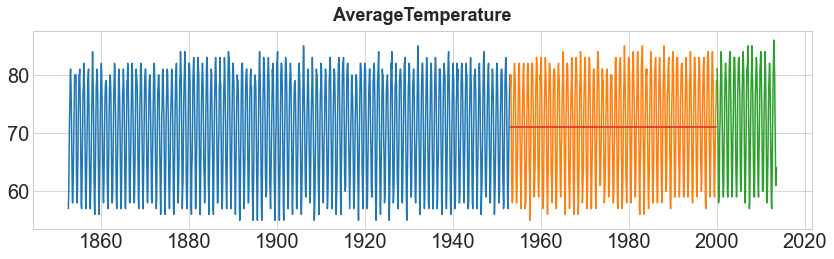

AverageTemperature --RMSE: 9.19


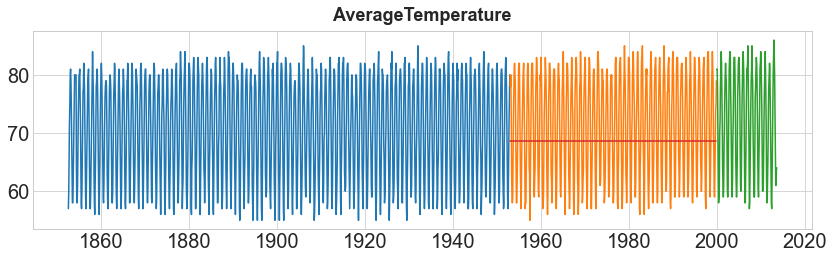

AverageTemperature --RMSE: 9.70


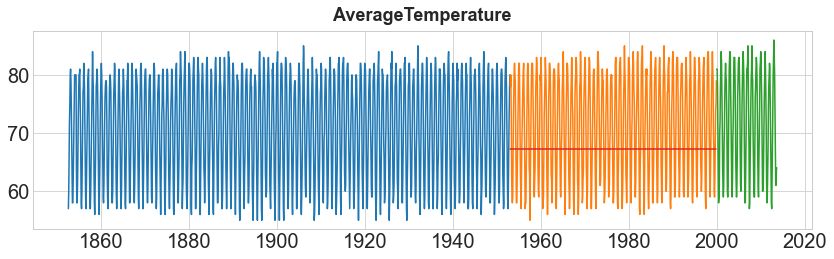

AverageTemperature --RMSE: 9.88


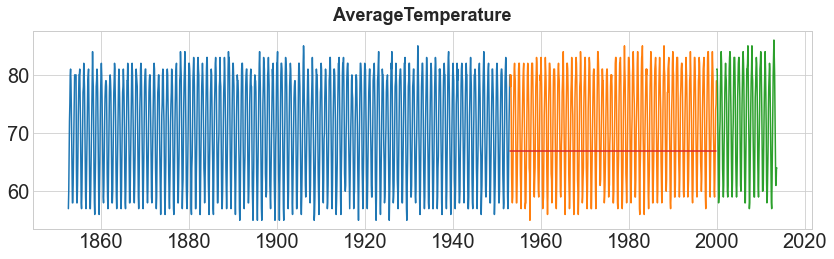

AverageTemperature --RMSE: 9.68


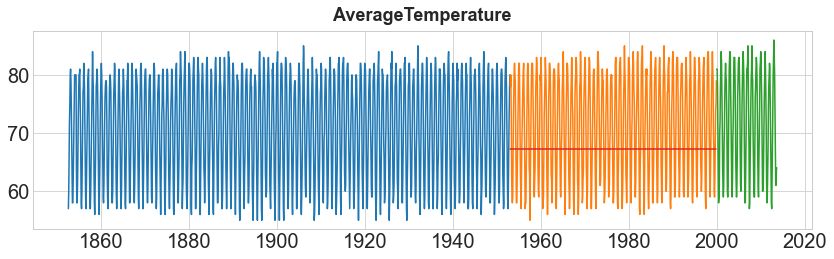

AverageTemperature --RMSE: 9.28


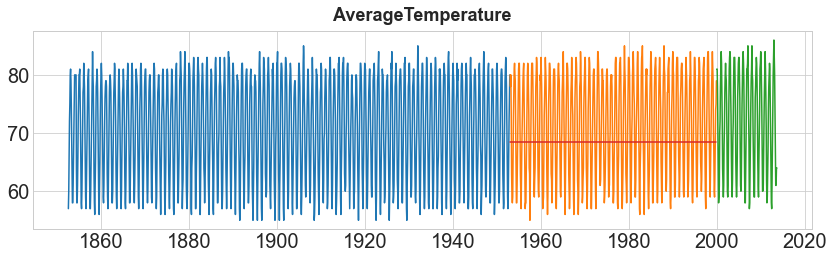

AverageTemperature --RMSE: 8.97


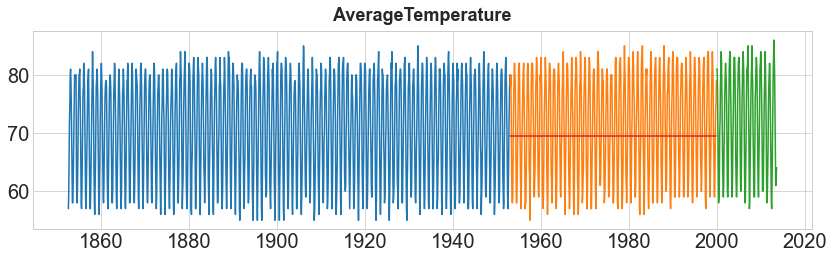

AverageTemperature --RMSE: 8.81


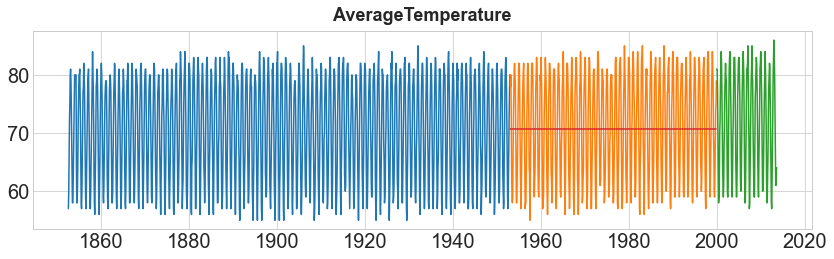

In [44]:
period = range(1, 13)

for i in period:
    temp = round(train['AverageTemperature'].rolling(i).mean().iloc[-1],2)
    yhat_df = make_predictions()
    for col in train.columns:
        plot_and_eval(col)
    for col in train.columns:
        eval_df = append_eval_df(model_type = f'moving_average_{i}_months', target_var = col)
    plt.show()

In [45]:
eval_df

model_type          target_var   rmse
0        last_observed_value  AverageTemperature  12.28
1             simple_average  AverageTemperature   8.81
2    moving_average_1_months  AverageTemperature  12.28
3    moving_average_2_months  AverageTemperature  10.97
4    moving_average_3_months  AverageTemperature   9.90
5    moving_average_4_months  AverageTemperature   9.08
6    moving_average_5_months  AverageTemperature   8.78
7    moving_average_6_months  AverageTemperature   9.19
8    moving_average_7_months  AverageTemperature   9.70
9    moving_average_8_months  AverageTemperature   9.88
10   moving_average_9_months  AverageTemperature   9.68
11  moving_average_10_months  AverageTemperature   9.28
12  moving_average_11_months  AverageTemperature   8.97
13  moving_average_12_months  AverageTemperature   8.81

### Holt-Winters

In [46]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .15,
                      smoothing_slope = .01,
                      optimized = False)

    yhat = model.predict(start = validate.index[0], end = validate.index[-1])

    yhat_df[col]= round(yhat, 2)

AverageTemperature --RMSE: 8.77


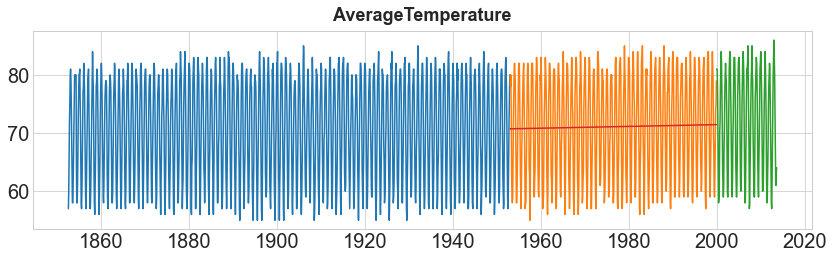

In [47]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)
    plot_and_eval(col)

## Precious Cycle

In [48]:
yhat_df = train.loc['1906':'1952'] + train.diff(12).mean()

In [49]:
yhat_df.index = validate.index

AverageTemperature --RMSE: 2.04


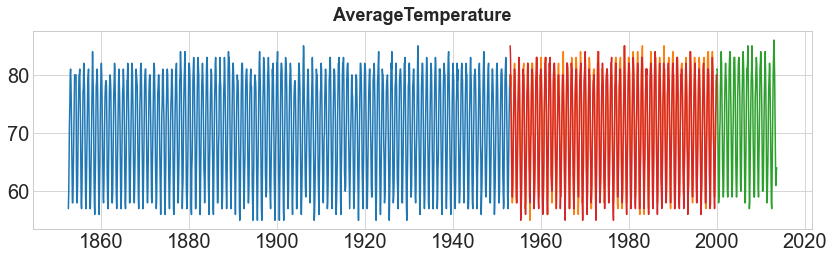

In [50]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'previous_cycle', target_var = col)
    plot_and_eval(col)

In [51]:
eval_df

model_type          target_var   rmse
0        last_observed_value  AverageTemperature  12.28
1             simple_average  AverageTemperature   8.81
2    moving_average_1_months  AverageTemperature  12.28
3    moving_average_2_months  AverageTemperature  10.97
4    moving_average_3_months  AverageTemperature   9.90
5    moving_average_4_months  AverageTemperature   9.08
6    moving_average_5_months  AverageTemperature   8.78
7    moving_average_6_months  AverageTemperature   9.19
8    moving_average_7_months  AverageTemperature   9.70
9    moving_average_8_months  AverageTemperature   9.88
10   moving_average_9_months  AverageTemperature   9.68
11  moving_average_10_months  AverageTemperature   9.28
12  moving_average_11_months  AverageTemperature   8.97
13  moving_average_12_months  AverageTemperature   8.81
14                     Holts  AverageTemperature   8.77
15            previous_cycle  AverageTemperature   2.04

In [52]:
## Pick the model with the lowest rmse
eval_df.sort_values(by=['rmse']).groupby('target_var').first()

model_type  rmse
target_var                              
AverageTemperature  previous_cycle  2.04

- OOOOO look at that previous cycle by far the best with an rmse of 2.04!!! this is our model!!


In [53]:
# lets test it now
train_val = aussie.loc['1852':'1999'].drop(columns = ['Country','AverageTemperatureUncertainty'])

In [54]:
# data ends in september so i have to chop off the last 3 months
yhat_df = train_val.loc['1986':'1999-09-01'] + train_val.diff(12).mean()

In [55]:
yhat_df.index = test.index

AverageTemperature --RMSE: 1.82


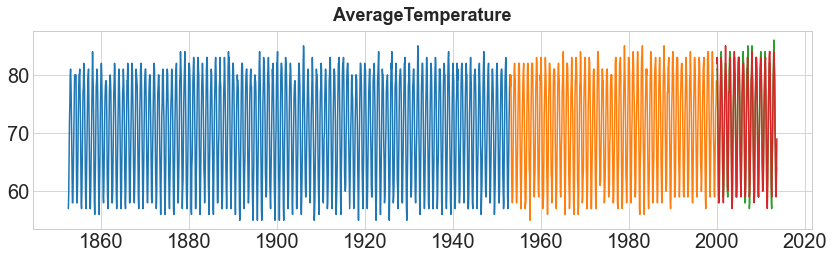

In [56]:
for col in train_val.columns:
    plot_and_eval_test(col)


- our test on useen data has an rmse of 1.82 which performed better than our validate it also blow our simple average out of the water!

In [57]:
# lets make our prediction now 
test + train_val.diff(12).mean()

AverageTemperature
dt                            
2000-01-01           81.014221
2000-02-01           81.014221
2000-03-01           78.014221
2000-04-01           71.014221
2000-05-01           63.014221
...                        ...
2013-05-01           67.014221
2013-06-01           61.014221
2013-07-01           61.014221
2013-08-01           64.014221
2013-09-01           64.014221

[165 rows x 1 columns]

In [70]:
test + train_val.diff(12).mean()
yhat_df.index = test.index + pd.Timedelta('13Y')

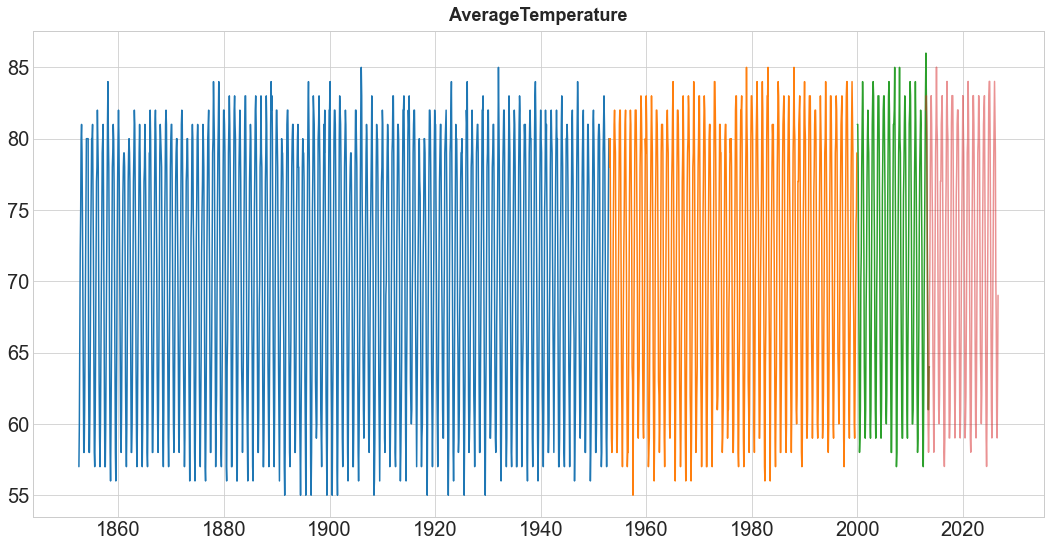

In [71]:
target_var = 'AverageTemperature'
plt.figure(figsize=(15,8))
plt.plot(train[target_var], label='train')
plt.plot(validate[target_var], label='validate')
plt.plot(test[target_var], label='test')
plt.plot(yhat_df[target_var], alpha=.5)
plt.title(target_var)
plt.show()

## Conclusion

Our model based off of previous cycles worked amazing! Recieving an RMSE of 1.82 degrees. This was better than our 'baseline' by almost 7 degrees. We were also able to accuratley predict the next 13 years from october 2013 to september 2026 based off of our model. 
 
Please if you have any questions do not hestitate to reach out. 